In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.compose import ColumnTransformer
from tqdm import tqdm
from typing import Callable

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from sales_forecasting.utils import timeseries_split
from sales_forecasting.plot import plot_timeseries, plot_feature_importance
from sales_forecasting.features import col_name

In [4]:
df = pd.read_parquet(".data/df_agg_monthly_oversampled.parquet")

In [5]:
train_split, valid_split = timeseries_split(df, max_month=33, col='date_block_num', continuous=False)
train_test_split, test_split = timeseries_split(df, max_month=34, col='date_block_num', continuous=False)

In [6]:
target_col = 'item_cnt_month'
train_target, valid_target = train_split[target_col].clip(0, 20), valid_split[target_col].clip(0, 20)

In [7]:
cols_to_drop = [target_col, 'date_block_num']
X_train, X_valid = train_split.drop(columns=cols_to_drop), valid_split.drop(columns=cols_to_drop)

# MLP

In [ ]:
X_train, X_valid = train_split.drop(columns=['shop_id', 'item_id']), valid_split.drop(columns=['shop_id', 'item_id'])

In [ ]:
ohe_cols = ['city_id', 'item_category_id', 'general_item_category_id', 'date_month']
num_cols = list(np.setdiff1d(X_train.columns, ohe_cols))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing.StandardScaler(), num_cols),
        ('cat', preprocessing.OneHotEncoder(handle_unknown='ignore'), ohe_cols)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

In [ ]:
class SalesPredictionMLPModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: list[int], dropout_rate: float, batch_norm: bool = True):
        super(SalesPredictionMLPModel, self).__init__()
        
        layers = []
        dims = [input_dim] + hidden_dim
        for in_dim, out_dim in zip(dims, dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if batch_norm:
                layers.append(nn.BatchNorm1d(out_dim))
            layers.extend([nn.Dropout(p=dropout_rate), nn.ReLU()])
        layers.append(nn.Linear(dims[-1], 1))

        self.ff = nn.Sequential(*layers)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.ff(X)

In [ ]:
class SalesMLPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
batch_size = 1024

train_dataset = SalesMLPDataset(X_train_preprocessed, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = SalesMLPDataset(X_valid_preprocessed, valid_target)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

dropout_rate = 0.2
input_dim = X_train_preprocessed.shape[1]
hidden_dim = [64, 32]
lr = 1e-5
device = torch.device("cpu")

model = SalesPredictionMLPModel(input_dim, hidden_dim, dropout_rate=dropout_rate).to(device)
criterion = F.mse_loss
optimizer = optim.Adam(model.parameters(), lr=lr)


In [ ]:
from typing import Callable

def train(
    model: nn.Module, 
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    device: torch.device, 
    epoch: int, 
    print_every: None | int = None
) -> float:
    model.train()
    train_loss = 0.

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        loss_item = loss.detach().cpu().item()

        if print_every is not None and batch_idx % print_every == 0:
            print(
                "Train (Batch): [{}/{} ({:.0f}%)]\tTrain Loss: {:.4f} \tTrain RMSE: {:.4f}".format(
                    batch_idx * len(data), len(train_loader.dataset), 100.0 * batch_idx / len(train_loader), loss_item, loss_item ** 0.5
                ) # type: ignore
            )
        train_loss += loss_item

    return train_loss


def test(
    model: nn.Module, 
    loss_fn: Callable,
    device: torch.device,
    test_loader: DataLoader, 
    print_every: None | int = None
) -> float:
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss =  loss_fn(output, target, reduction="sum")

            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)

    if print_every is not None:
        print(
            "\nTest: Test loss: {:.4f} \t Test RMSE: {:.4f}\n".format(test_loss, test_loss ** 2) # type: ignore
        )
    
    return test_loss

In [ ]:
history = {
    'train_loss': [],
    'val_loss': []
}
for epoch in tqdm(range(1, 6)):
    history['train_loss'].append(train(model, criterion, optimizer, train_loader, device, epoch, print_every=1000))
    history['val_loss'].append(test(model, criterion, device, valid_loader))

history['train_loss'] = np.array(history['train_loss'])
history['val_loss'] = np.array(history['val_loss'])

In [ ]:
train_loss

In [ ]:
history['train_loss'] = np.array(history['train_loss'])
history['val_loss'] = np.array(history['val_loss'])

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label="Training Loss")
    plt.plot(history['val_loss'], label="Validation Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'] ** 0.5, label="Training RMSE")
    plt.plot(history['val_loss'] ** 0.5, label="Validation RMSE")
    plt.title("RMSE Curve")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()

    plt.show()

plot_history(history)

# RNN

In [8]:
X_train = X_train.assign(item_cnt_month=train_target)
X_valid = X_valid.assign(item_cnt_month=valid_target)
X_train_valid = pd.concat([X_train, X_valid])

In [9]:
X_train

/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,shop_id,item_id,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,lagged_1,lagged_2,...,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy,item_cnt_month
0,0,0,0,40,11,8,0.866211,-0.500000,0,0,...,169.0,1.0,4488.0,1.000000,270.50,1.163086,264.00,1.080078,0,0
1,0,0,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,4488.0,1.000000,263.50,1.150391,265.50,1.080078,1,0
2,0,0,0,40,11,10,0.500000,-0.866211,0,0,...,169.0,1.0,4488.0,1.000000,263.75,1.170898,263.75,1.087891,2,0
3,0,0,0,40,11,11,0.258789,-0.965820,0,0,...,169.0,1.0,4488.0,1.000000,262.25,1.138672,264.00,1.089844,3,0
4,0,0,0,40,11,0,0.000000,1.000000,0,0,...,169.0,1.0,4488.0,1.000000,262.50,1.228516,262.00,1.131836,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29460948,59,22169,30,69,14,4,0.866211,0.500000,0,0,...,299.0,1.0,169.0,1.069336,1042.00,1.000000,1093.00,1.047852,14,0
29460949,59,22169,30,69,14,5,0.965820,0.258789,0,0,...,299.0,1.0,169.0,1.069336,489.00,1.000000,1130.00,1.031250,15,0
29460950,59,22169,30,69,14,6,1.000000,0.000000,0,0,...,299.0,1.0,169.0,1.069336,1080.00,1.125000,938.50,1.047852,16,0
29460951,59,22169,30,69,14,7,0.965820,-0.258789,0,0,...,299.0,1.0,169.0,1.069336,553.00,1.151367,738.50,1.071289,17,0


In [10]:
X_valid

/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,shop_id,item_id,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,lagged_1,lagged_2,...,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy,item_cnt_month
13,0,0,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,4488.0,1.000000,297.00,1.083984,279.500,1.045898,13,0
32,0,1,0,76,15,9,0.707031,-0.707031,0,0,...,169.0,1.0,4488.0,1.000000,297.00,1.083984,1939.000,1.550781,18,0
47,0,2,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,58.0,1.000000,297.00,1.083984,279.500,1.045898,14,0
63,0,3,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,100.0,1.000000,297.00,1.083984,279.500,1.045898,15,0
77,0,4,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,58.0,1.000000,297.00,1.083984,279.500,1.045898,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29460846,59,22165,30,31,8,9,0.707031,-0.707031,0,0,...,699.0,1.0,59.0,1.000000,353.25,1.000000,664.500,1.254883,26,0
29460871,59,22166,30,54,12,9,0.707031,-0.707031,0,0,...,699.0,1.0,150.0,1.250000,353.25,1.000000,228.625,1.278320,24,0
29460898,59,22167,30,49,12,9,0.707031,-0.707031,0,0,...,299.0,1.0,299.0,1.049805,334.50,1.000000,469.500,1.098633,15,0
29460933,59,22168,30,62,14,9,0.707031,-0.707031,0,0,...,299.0,1.0,798.5,1.000000,899.00,1.000000,1558.000,1.097656,33,0


In [11]:
X_train_valid

/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,shop_id,item_id,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,lagged_1,lagged_2,...,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy,item_cnt_month
0,0,0,0,40,11,8,0.866211,-0.500000,0,0,...,169.0,1.0,4488.0,1.000000,270.50,1.163086,264.000,1.080078,0,0
1,0,0,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,4488.0,1.000000,263.50,1.150391,265.500,1.080078,1,0
2,0,0,0,40,11,10,0.500000,-0.866211,0,0,...,169.0,1.0,4488.0,1.000000,263.75,1.170898,263.750,1.087891,2,0
3,0,0,0,40,11,11,0.258789,-0.965820,0,0,...,169.0,1.0,4488.0,1.000000,262.25,1.138672,264.000,1.089844,3,0
4,0,0,0,40,11,0,0.000000,1.000000,0,0,...,169.0,1.0,4488.0,1.000000,262.50,1.228516,262.000,1.131836,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29460846,59,22165,30,31,8,9,0.707031,-0.707031,0,0,...,699.0,1.0,59.0,1.000000,353.25,1.000000,664.500,1.254883,26,0
29460871,59,22166,30,54,12,9,0.707031,-0.707031,0,0,...,699.0,1.0,150.0,1.250000,353.25,1.000000,228.625,1.278320,24,0
29460898,59,22167,30,49,12,9,0.707031,-0.707031,0,0,...,299.0,1.0,299.0,1.049805,334.50,1.000000,469.500,1.098633,15,0
29460933,59,22168,30,62,14,9,0.707031,-0.707031,0,0,...,299.0,1.0,798.5,1.000000,899.00,1.000000,1558.000,1.097656,33,0


In [12]:
def build_vector_tuples(X: pd.DataFrame, save_path: str | None = None):
    embed_cols = ['shop_id', 'item_id', 'city_id', 'item_category_id', 'general_item_category_id']
    embed_entity_index = X[embed_cols].drop_duplicates().reset_index(drop=True)

    seq_cols = np.setdiff1d(X.columns, embed_cols + ['item_cnt_month'])

    vector_tuples = []
    for (shop_id, item_id), group in tqdm(X.groupby(['shop_id', 'item_id'])):
        embed_entities = embed_entity_index[(embed_entity_index.shop_id == shop_id) & (embed_entity_index.item_id == item_id)].values
        seq_matrix = group[seq_cols].values
        target = group['item_cnt_month'].values[-1]
        vector_tuples.append((embed_entities, seq_matrix, target))

    if save_path is not None:
        import pickle
        with open(save_path, 'wb') as f:
            pickle.dump(vector_tuples, f)
    
    return vector_tuples

In [13]:
read = True
if read:
    import pickle
    with open(".data/X_train_vector_tuples.pkl", 'rb') as f:
        X_train_vector_tuples = pickle.load(f)
    with open(".data/X_valid_vector_tuples.pkl", 'rb') as f:
        X_valid_vector_tuples = pickle.load(f)
else:
    X_train_vector_tuples = build_vector_tuples(X_train, save_path=".data/X_train_vector_tuples.pkl")
    X_valid_vector_tuples = build_vector_tuples(X_train_valid, save_path=".data/X_valid_vector_tuples.pkl")

In [14]:
def pad_sequences(matrices):
    L = len(matrices)
    D = matrices[0].shape[1]
    K = max(matrix.shape[0] for matrix in matrices)

    padded_tensor = torch.zeros((L, K, D), dtype=torch.float32)

    for i, matrix in enumerate(matrices):
        n = matrix.shape[0]
        padded_tensor[i, :n, :] = torch.tensor(matrix, dtype=torch.float32)
    return padded_tensor

def pad_sequences1d(sequences):
    L = len(sequences)
    K = max(len(seq) for seq in sequences)

    padded_tensor = torch.zeros((L, K), dtype=torch.float32)

    for i, seq in enumerate(sequences):
        n = len(seq)
        padded_tensor[i, :n] = torch.tensor(seq, dtype=torch.float32)
    return padded_tensor

In [15]:
class SalesDataset(Dataset):
    def __init__(self, df_tuples_array: list[tuple[np.ndarray, np.ndarray, np.ndarray]]):
        self.df = df_tuples_array
        self.embed_entities = torch.tensor([x[0] for x in self.df], dtype=torch.long).squeeze(1)
        self.seq_matr = pad_sequences([torch.tensor(x[1], dtype=torch.float32) for x in self.df])
        
        self.targets = torch.tensor([x[2] for x in self.df], dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (self.embed_entities[idx], 
                self.seq_matr[idx],
                self.targets[idx])


In [16]:
class SalesPredictionModel(nn.Module):
    def __init__(self, emb_cardinality, embedding_size, dropout_rate, seq_input_size):
        super(SalesPredictionModel, self).__init__()
        
        # Embedding layers for categorical variables
        self._embedding_size = embedding_size
        self._emb_cardinality = emb_cardinality
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings, self._embedding_size) 
            for num_embeddings in self._emb_cardinality
        ])
        self._emb_dim_sum = len(self._emb_cardinality) * self._embedding_size

        # LSTM layer
        self._lstm_input_size = seq_input_size
        self._lstm_hidden_size = 2 * embedding_size
        self.lstm = nn.LSTM(
            input_size=self._lstm_input_size,
            hidden_size=self._lstm_hidden_size,
            batch_first=True
        )
        
        # Fully connected layer
        self._fc_input_size = self._lstm_hidden_size + self._emb_dim_sum
        self.fc = nn.Linear(self._fc_input_size, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.1)

    def forward(self, embed, seq):
        # Embedding layers
        embedded_features = [embedding(embed[:, i]) for i, embedding in enumerate(self.embeddings)]
        emb_tensors = torch.cat(embedded_features, dim=1)
        #emb_tensors = self.dropout(emb_tensors) 

        # LSTM
        _, (lstm_hidden_state, _) = self.lstm(seq)
        lstm_hidden_state = lstm_hidden_state[-1]

        # Concatenate embeddings and LSTM output
        concatenated = torch.cat([emb_tensors, lstm_hidden_state], dim=1)

        output = self.fc(concatenated)

        return output

In [29]:
batch_size = 4096

train_dataset = SalesDataset(X_train_vector_tuples)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SalesDataset(X_valid_vector_tuples)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_93432/1370659372.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor[i, :n, :] = torch.tensor(matrix, dtype=torch.float32)


In [30]:
# Parameters
emb_cardinality = X_train.shop_id.max()+1, X_train.item_id.max()+1, X_train.city_id.max()+1, X_train.item_category_id.max()+1, X_train.general_item_category_id.max()+1
embedding_size = 16
dropout_rate = 0.3
seq_input_size = 26
lr = 1e-4
device = torch.device("cpu")

model = SalesPredictionModel(emb_cardinality, embedding_size, dropout_rate, seq_input_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [19]:
model

SalesPredictionModel(
  (embeddings): ModuleList(
    (0): Embedding(60, 16)
    (1): Embedding(22170, 16)
    (2): Embedding(31, 16)
    (3): Embedding(84, 16)
    (4): Embedding(20, 16)
  )
  (lstm): LSTM(26, 32, batch_first=True)
  (fc): Linear(in_features=112, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [31]:
def train(
    model: nn.Module, 
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    device: torch.device, 
    epoch: int, 
    print_every: None | int = None
) -> float:
    model.train()
    train_loss = 0.

    for batch_idx, batch in enumerate(train_loader):
        embed, seq, target = (_.to(device) for _ in batch)
        
        optimizer.zero_grad()
        output = model(embed, seq)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        loss_item = loss.detach().cpu().item()

        if print_every is not None and batch_idx % print_every == 0:
            print(
                "Train (Batch): [{}/{} ({:.0f}%)]\tTrain Loss: {:.4f} \tTrain RMSE: {:.4f}".format(
                    batch_idx, len(train_loader), 100.0 * batch_idx / len(train_loader), loss_item, loss_item ** 0.5
                ) # type: ignore
            )
        train_loss += loss_item

    train_loss /= len(train_loader)

    return train_loss


def test(
    model: nn.Module, 
    loss_fn: Callable,
    device: torch.device,
    test_loader: DataLoader, 
    print_every: None | int = None
) -> float:
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            embed, seq, target = (_.to(device) for _ in batch)
            output = model(embed, seq)
            loss =  loss_fn(output, target)

            loss_item = loss.detach().cpu().item()
            test_loss += loss_item

    test_loss /= len(test_loader)

    if print_every is not None:
        print(
            "\nTest: Test loss: {:.4f} \t Test RMSE: {:.4f}\n".format(test_loss, test_loss ** 0.5) # type: ignore
        )
    
    return test_loss

In [32]:
history = {
    'train_loss': [],
    'val_loss': []
}

EPOCHS = 15
for epoch in tqdm(range(1, EPOCHS + 1)):
    history['train_loss'].append(train(model, criterion, optimizer, train_loader, device, epoch, print_every=100))
    history['val_loss'].append(test(model, criterion, device, val_loader, print_every=1))

history['train_loss'] = np.array(history['train_loss'])
history['val_loss'] = np.array(history['val_loss'])

history['train_rmse'] = history['train_loss'] ** 0.5
history['val_rmse'] = history['val_loss'] ** 0.5

  0%|          | 0/15 [00:00<?, ?it/s]

Train (Batch): [0/292 (0%)]	Train Loss: 0.4061 	Train RMSE: 0.6373
Train (Batch): [100/292 (34%)]	Train Loss: 0.3762 	Train RMSE: 0.6133
Train (Batch): [200/292 (68%)]	Train Loss: 0.2939 	Train RMSE: 0.5421


  7%|▋         | 1/15 [00:34<08:03, 34.55s/it]


Test: Test loss: 0.3012 	 Test RMSE: 0.5488

Train (Batch): [0/292 (0%)]	Train Loss: 0.3586 	Train RMSE: 0.5989
Train (Batch): [100/292 (34%)]	Train Loss: 0.2399 	Train RMSE: 0.4898
Train (Batch): [200/292 (68%)]	Train Loss: 0.1890 	Train RMSE: 0.4347


 13%|█▎        | 2/15 [01:09<07:34, 34.99s/it]


Test: Test loss: 0.2699 	 Test RMSE: 0.5195

Train (Batch): [0/292 (0%)]	Train Loss: 0.1790 	Train RMSE: 0.4231
Train (Batch): [100/292 (34%)]	Train Loss: 0.2478 	Train RMSE: 0.4978
Train (Batch): [200/292 (68%)]	Train Loss: 0.1128 	Train RMSE: 0.3358


 20%|██        | 3/15 [01:46<07:08, 35.70s/it]


Test: Test loss: 0.2577 	 Test RMSE: 0.5076

Train (Batch): [0/292 (0%)]	Train Loss: 0.2272 	Train RMSE: 0.4766
Train (Batch): [100/292 (34%)]	Train Loss: 0.2535 	Train RMSE: 0.5035
Train (Batch): [200/292 (68%)]	Train Loss: 0.1348 	Train RMSE: 0.3672


 27%|██▋       | 4/15 [02:20<06:25, 35.09s/it]


Test: Test loss: 0.2475 	 Test RMSE: 0.4975

Train (Batch): [0/292 (0%)]	Train Loss: 0.3958 	Train RMSE: 0.6291
Train (Batch): [100/292 (34%)]	Train Loss: 0.5513 	Train RMSE: 0.7425
Train (Batch): [200/292 (68%)]	Train Loss: 0.1208 	Train RMSE: 0.3476


 33%|███▎      | 5/15 [02:54<05:48, 34.86s/it]


Test: Test loss: 0.2441 	 Test RMSE: 0.4941

Train (Batch): [0/292 (0%)]	Train Loss: 0.2006 	Train RMSE: 0.4479
Train (Batch): [100/292 (34%)]	Train Loss: 0.3414 	Train RMSE: 0.5843
Train (Batch): [200/292 (68%)]	Train Loss: 0.1974 	Train RMSE: 0.4443


 40%|████      | 6/15 [03:29<05:13, 34.84s/it]


Test: Test loss: 0.2432 	 Test RMSE: 0.4931

Train (Batch): [0/292 (0%)]	Train Loss: 0.2857 	Train RMSE: 0.5345
Train (Batch): [100/292 (34%)]	Train Loss: 0.2246 	Train RMSE: 0.4740
Train (Batch): [200/292 (68%)]	Train Loss: 0.2589 	Train RMSE: 0.5089


 47%|████▋     | 7/15 [04:04<04:38, 34.84s/it]


Test: Test loss: 0.2403 	 Test RMSE: 0.4903

Train (Batch): [0/292 (0%)]	Train Loss: 0.3152 	Train RMSE: 0.5615
Train (Batch): [100/292 (34%)]	Train Loss: 0.3725 	Train RMSE: 0.6103
Train (Batch): [200/292 (68%)]	Train Loss: 0.0835 	Train RMSE: 0.2889


 53%|█████▎    | 8/15 [04:39<04:02, 34.71s/it]


Test: Test loss: 0.2368 	 Test RMSE: 0.4866

Train (Batch): [0/292 (0%)]	Train Loss: 0.2244 	Train RMSE: 0.4737
Train (Batch): [100/292 (34%)]	Train Loss: 0.1635 	Train RMSE: 0.4043
Train (Batch): [200/292 (68%)]	Train Loss: 0.2537 	Train RMSE: 0.5036


 60%|██████    | 9/15 [05:13<03:28, 34.75s/it]


Test: Test loss: 0.2380 	 Test RMSE: 0.4878

Train (Batch): [0/292 (0%)]	Train Loss: 0.4374 	Train RMSE: 0.6613
Train (Batch): [100/292 (34%)]	Train Loss: 0.1726 	Train RMSE: 0.4155
Train (Batch): [200/292 (68%)]	Train Loss: 0.1525 	Train RMSE: 0.3905


 67%|██████▋   | 10/15 [05:49<02:54, 34.92s/it]


Test: Test loss: 0.2365 	 Test RMSE: 0.4863

Train (Batch): [0/292 (0%)]	Train Loss: 0.3528 	Train RMSE: 0.5940
Train (Batch): [100/292 (34%)]	Train Loss: 0.1393 	Train RMSE: 0.3733
Train (Batch): [200/292 (68%)]	Train Loss: 0.1893 	Train RMSE: 0.4351


 73%|███████▎  | 11/15 [06:24<02:20, 35.02s/it]


Test: Test loss: 0.2334 	 Test RMSE: 0.4831

Train (Batch): [0/292 (0%)]	Train Loss: 0.3170 	Train RMSE: 0.5631
Train (Batch): [100/292 (34%)]	Train Loss: 0.1670 	Train RMSE: 0.4087
Train (Batch): [200/292 (68%)]	Train Loss: 0.3228 	Train RMSE: 0.5682


 80%|████████  | 12/15 [06:59<01:45, 35.04s/it]


Test: Test loss: 0.2366 	 Test RMSE: 0.4865

Train (Batch): [0/292 (0%)]	Train Loss: 0.0968 	Train RMSE: 0.3111
Train (Batch): [100/292 (34%)]	Train Loss: 0.3064 	Train RMSE: 0.5535
Train (Batch): [200/292 (68%)]	Train Loss: 0.1470 	Train RMSE: 0.3834


 87%|████████▋ | 13/15 [07:33<01:09, 34.82s/it]


Test: Test loss: 0.2291 	 Test RMSE: 0.4786

Train (Batch): [0/292 (0%)]	Train Loss: 0.0621 	Train RMSE: 0.2493
Train (Batch): [100/292 (34%)]	Train Loss: 0.2838 	Train RMSE: 0.5328
Train (Batch): [200/292 (68%)]	Train Loss: 0.0915 	Train RMSE: 0.3024


 93%|█████████▎| 14/15 [08:08<00:34, 34.68s/it]


Test: Test loss: 0.2318 	 Test RMSE: 0.4814

Train (Batch): [0/292 (0%)]	Train Loss: 0.1539 	Train RMSE: 0.3923
Train (Batch): [100/292 (34%)]	Train Loss: 0.1803 	Train RMSE: 0.4247
Train (Batch): [200/292 (68%)]	Train Loss: 0.0982 	Train RMSE: 0.3133


100%|██████████| 15/15 [08:44<00:00, 34.94s/it]


Test: Test loss: 0.2292 	 Test RMSE: 0.4788



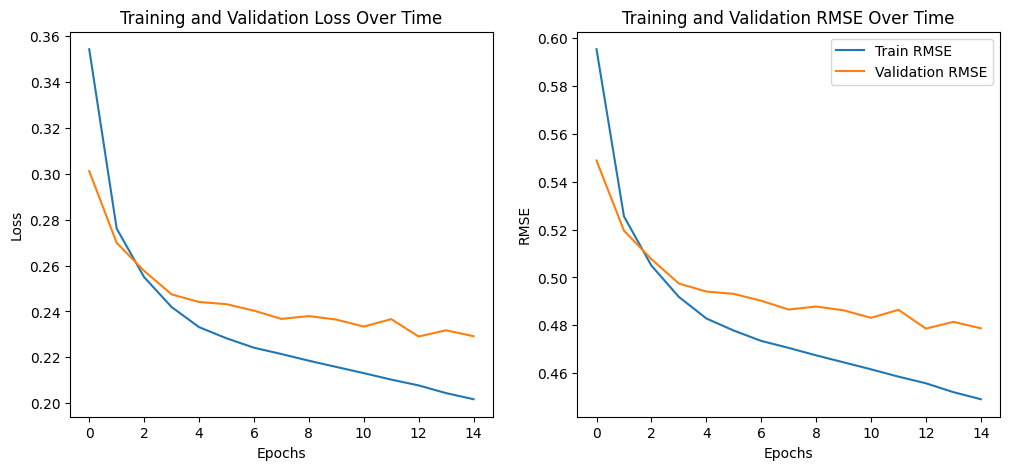

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(history['train_loss'], label='Train Loss')
ax[0].plot(history['val_loss'], label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss Over Time')

ax[1].plot(history['train_rmse'], label='Train RMSE')
ax[1].plot(history['val_rmse'], label='Validation RMSE')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('RMSE')
ax[1].set_title('Training and Validation RMSE Over Time')

plt.legend()
plt.show()

In [ ]:
rmse = metrics.root_mean_squared_error(valid_target.values, y_pred)